In [2]:
import numpy as np
import pandas as pd
import json
import os

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
import pennylane as qml

In [87]:
for cutoff in [2,4,8,16]:
    num_qubits =  1 + np.log2(cutoff)
    num_layers = 1
    params_shape = qml.StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=num_qubits)
    print(num_qubits,params_shape)

2.0 (1, np.float64(2.0), 3)
3.0 (1, np.float64(3.0), 3)
4.0 (1, np.float64(4.0), 3)
5.0 (1, np.float64(5.0), 3)


In [82]:
sel_path = r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\SUSY QM\PennyLane\VQE\Differential Evolution\StronglyEntanglingLayers\Noise"
adapt_path = r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\SUSY QM\PennyLane\ADAPT-VQE\VQE Runs\Files"
real_path = r"C:\Users\johnkerf\Desktop\Quantum-Computing\Quantum-Computing\SUSY\SUSY QM\PennyLane\VQE\Differential Evolution\RealAmplitudes\Noise"

potentials = ['QHO', 'AHO', 'DW']

cutoffs = [2, 4, 8, 16, 32, 64, 128, 256, 512]

In [68]:
def get_data(path, converged_only=True):

    times = {potential: [] for potential in potentials}
    lower_std = {potential: [] for potential in potentials}
    upper_std = {potential: [] for potential in potentials}
    delta_e = {potential: [] for potential in potentials}

    for potential in potentials:
        for cutoff in cutoffs:

            
            file_path = os.path.join(path, potential, f"{potential}_{cutoff}.json")
            
            with open(file_path, 'r') as f:
                data = json.load(f)


            converged_indices = [i for i, success in enumerate(data['success']) if success]

            if converged_only:
                run_times = [data['run_times'][i] for i in converged_indices]
            else:
                run_times = data['run_times']
                
            t_sec = np.array([pd.Timedelta(t).seconds for t in run_times])
            mean_vqe_time = np.mean(t_sec)
            times[potential].append(mean_vqe_time)

            #std_vqe_time = np.std(t_sec)
            ustd = np.std(t_sec[t_sec >= mean_vqe_time], ddof=1)
            lstd = np.std(t_sec[t_sec <= mean_vqe_time], ddof=1)
            lower_std[potential].append(lstd)
            upper_std[potential].append(ustd)

            
            exact_min_e = np.min(data['exact_eigenvalues'])
            median_e = np.mean([data['results'][i] for i in converged_indices])
            delta_median_e = (abs(exact_min_e - median_e)) 
            delta_e[potential].append(delta_median_e)

    return times, lower_std, upper_std, delta_e

In [69]:
adapt_times, adapt_lower_std, adapt_upper_std, adapt_delta_e = get_data(adapt_path, converged_only=True)
real_times, real_lower_std, real_upper_std, real_delta_e = get_data(real_path,converged_only=True)
sel_times, sel_lower_std, sel_upper_std, sel_delta_e = get_data(sel_path,converged_only=True)

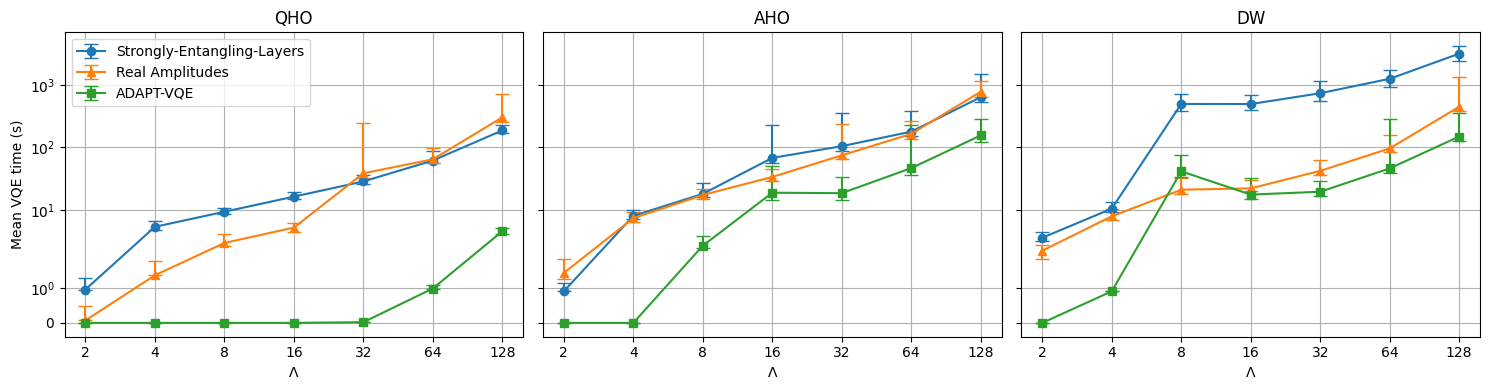

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, potential in enumerate(potentials):
    axs[i].errorbar(cutoffs, sel_times[potential], yerr=[sel_lower_std[potential],sel_upper_std[potential]], marker='o', capsize=5, label='Strongly-Entangling-Layers')
    axs[i].errorbar(cutoffs, real_times[potential], yerr=[real_lower_std[potential],real_upper_std[potential]],marker='^', capsize=5, label='Real Amplitudes')
    axs[i].errorbar(cutoffs, adapt_times[potential], yerr=[adapt_lower_std[potential],adapt_upper_std[potential]],marker='s', capsize=5, label='ADAPT-VQE')
    axs[i].set_title(f'{potential}')
    axs[i].set_xlabel('$\\Lambda$')
    axs[i].set_xscale('log')
    axs[i].set_yscale('symlog')
    axs[i].set_xticks(cutoffs)
    axs[i].xaxis.set_major_formatter(ticker.ScalarFormatter())
    axs[i].xaxis.set_minor_locator(ticker.NullLocator())
    axs[i].ticklabel_format(style='plain', axis='x')
    axs[i].grid(True)
    
    if i == 0:
        axs[i].set_ylabel('Mean VQE time (s)')
        axs[i].legend()

plt.tight_layout()
plt.show()


In [78]:
def get_optimiser_time(path):

    opt_times = {potential: [] for potential in potentials}
    device_times = {potential: [] for potential in potentials}

    for potential in potentials:
        for cutoff in cutoffs:

            file_path = os.path.join(path, potential, f"{potential}_{cutoff}.json")
            
            with open(file_path, 'r') as f:
                data = json.load(f)
        
            total_vqe = pd.Timedelta(data['total_VQE_time']).seconds
            total_device = pd.Timedelta(data['total_device_time']).seconds

            optimiser_time = total_vqe-total_device

            opt_times[potential].append(optimiser_time)
            device_times[potential].append(total_device)

    return opt_times, device_times
        

In [83]:
adapt_opt_time, adapt_device_time = get_optimiser_time(adapt_path)
#real_opt_time, real_device_time = get_optimiser_time(real_path)

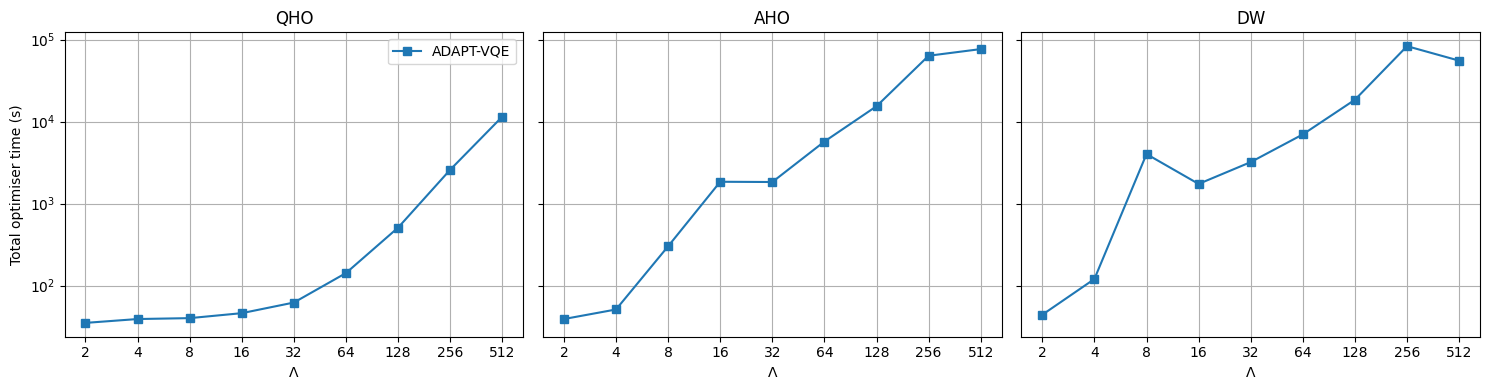

In [84]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, potential in enumerate(potentials):
    #axs[i].errorbar(cutoffs, sel_times[potential], yerr=[sel_lower_std[potential],sel_upper_std[potential]], marker='o', capsize=5, label='Strongly-Entangling-Layers')
    #axs[i].plot(cutoffs, real_opt_time[potential], marker='^', label='Real Amplitudes')
    axs[i].plot(cutoffs, adapt_opt_time[potential], marker='s', label='ADAPT-VQE')
    axs[i].set_title(f'{potential}')
    axs[i].set_xlabel('$\\Lambda$')
    axs[i].set_xscale('log')
    axs[i].set_yscale('symlog')
    axs[i].set_xticks(cutoffs)
    axs[i].xaxis.set_major_formatter(ticker.ScalarFormatter())
    axs[i].xaxis.set_minor_locator(ticker.NullLocator())
    axs[i].ticklabel_format(style='plain', axis='x')
    axs[i].grid(True)
    
    if i == 0:
        axs[i].set_ylabel('Total optimiser time (s)')
        axs[i].legend()

plt.tight_layout()
plt.show()


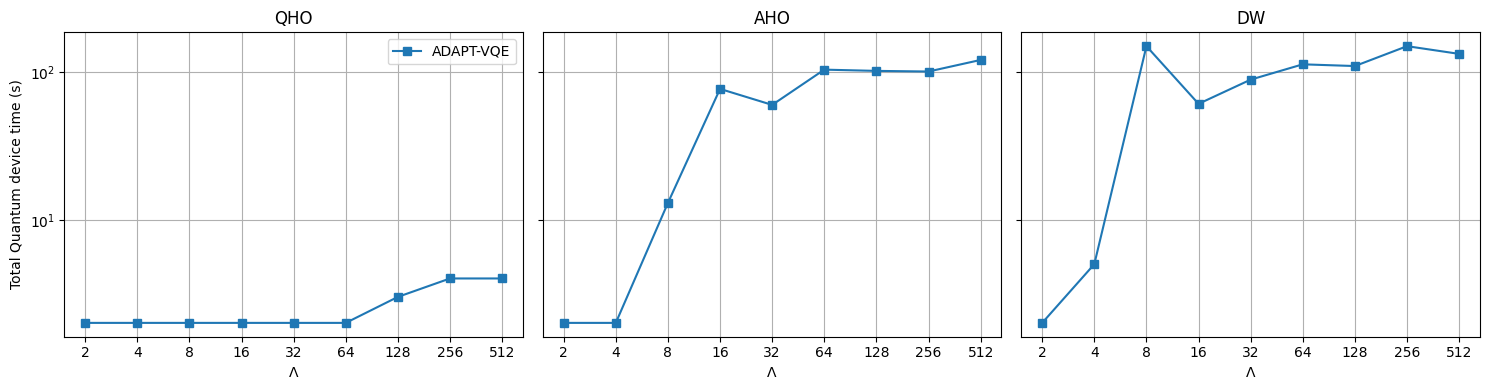

In [85]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, potential in enumerate(potentials):
    #axs[i].errorbar(cutoffs, sel_times[potential], yerr=[sel_lower_std[potential],sel_upper_std[potential]], marker='o', capsize=5, label='Strongly-Entangling-Layers')
    #axs[i].plot(cutoffs, real_device_time[potential], marker='^', label='Real Amplitudes')
    axs[i].plot(cutoffs, adapt_device_time[potential], marker='s', label='ADAPT-VQE')
    axs[i].set_title(f'{potential}')
    axs[i].set_xlabel('$\\Lambda$')
    axs[i].set_xscale('log')
    axs[i].set_yscale('symlog')
    axs[i].set_xticks(cutoffs)
    axs[i].xaxis.set_major_formatter(ticker.ScalarFormatter())
    axs[i].xaxis.set_minor_locator(ticker.NullLocator())
    axs[i].ticklabel_format(style='plain', axis='x')
    axs[i].grid(True)
    
    if i == 0:
        axs[i].set_ylabel('Total Quantum device time (s)')
        axs[i].legend()

plt.tight_layout()
plt.show()
